# Werkje gegevensbanken 2018 - DEEL 04

## Inleiding

Het vierde en laatste deel van het werkje bestaat uit twee componenten: 
1. Optimalisatie
2. Visualisatie

Bij dit deel van het werkje laten we jullie veel vrijheid om tot een oplossing te komen. Er bestaat niet zoiets als de unieke correcte oplossing, het is dus de bedoeling dat jullie zelf een strategie uitdokteren en deze achteraf kunnen verdedigen. Leg in deze notebook kort uit welke keuzes je maakt en waarom, dit zal helpen bij de verdediging. Beschouw dit als een soort mini-verslag tussen de code door.

### Indienen + Evaluatiemoment

** EVALULATIEMOMENT**: DE OEFENZITTING IN DE WEEK VAN 14/05/2017-18/05/2017

Het evaluatiemoment van het **volledige** werkje vindt plaats tijdens **de oefenzitting in de week van 14/05/2017-18/05/2017**. Prof. Berendt en dr. Bogaerts komen langs om enkele vragen te stellen over jullie oplossingen. Dit evaluatiemoment omvat ook een demonstratie van jullie resultaat, bijvoorbeeld: aantonen dat jullie optimalisatie van deel 4 van het werkje effectief een verbetering is t.o.v. het originele geval. Teneinde die demonstratie vlot te doen verlopen vragen we jullie om **per groep (minstens) 1 laptop mee te nemen waarop jullie oplossingen (i.e. de ingevulde notebooks) goed functioneren**. Deze laptop beschikt dus ook over XAMPP (inclusief de gegevensbank van dit werkje, uiteraard), gezien de queries in de notebooks ook moeten werken.

**INDIENDEADLINE**: ZONDAG 13 MEI om 23.59

** HOE INDIENEN**:
    1. Upload je ingevulde notebook als werkje_04_groep_XX.ipynb EN werkje_04_groep_XX.html 
    2. Vervang XX door je groepsnummer.
    3. Uploaden doe je op Toledo in je groepsfolder.
    
Zorg ervoor dat de .html file zeker ook de output van de visualisatie bevat, zodat wij deze gemakkelijk kunnen bekijken en niet moeten reproduceren door jullie .ipynb te runnen! Op die manier kunnen we zeker zijn dat we evalueren wat jullie geproduceerd hebben.

### Nuttige packages en functies inladen

Enkele nuttige packages en functies inladen die verderop van pas zullen komen.

In [2]:
# Benodigde packages
import json            # Package om .json files in te laden (bvb kolomnamen zijn zo opgeslagen)
import getpass         # Package om een paswoordveldje te genereren.
import mysql.connector # MySQL package
import numpy as np
import pandas as pd    # Populaire package voor data-verwerking
import sys
import os
import time

In [3]:
sys.version_info       # Check python versie, wij veronderstellen 3.6

sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)

### Interageren met een gegevensbank

In [4]:
def verbind_met_GB(username, hostname, gegevensbanknaam):
    """
    Maak verbinding met een externe gegevensbank
    
    :param  username:          username van de gebruiker, string
    :param  hostname:          naam van de host, string.
                               Dit is in het geval van een lokale server gewoon 'localhost'
    :param  gegevensbanknaam:  naam van de gegevensbank, string.
    :return connection:        connection object, dit is wat teruggeven wordt 
                               door connect() methods van packages die voldoen aan de DB-API
    """
    
    password = getpass.getpass() # Genereer vakje voor wachtwoord in te geven
    
    connection = mysql.connector.connect(host=hostname,
                                         user=username,
                                         passwd=password,
                                         db=gegevensbanknaam)
    return connection


def check_perfect_match(df1, df2):
    """
    Functie om te checken of 2 DataFrames gelijk zijn.
    """
    check = df1.equals(df2)
    return check


def run_query(connection, query, must_return = True):
    """
    Voer een query uit op een reeds gemaakte connectie, geeft het resultaat van de query terug
    """
    
    # Making a cursor and executing the query
    cursor = connection.cursor()
    cursor.execute(query)
    
    # Collecting the result and casting it in a pd.DataFrame
    
    if must_return:
        res = cursor.fetchall()
        return res
    else:
        return


def res_to_df(query_result, column_names):
    """
    Giet het resultaat van een uitgevoerde query in een 'pandas dataframe'
    met vooraf gespecifieerde kolomnamen.
    
    Let op: Het resultaat van de query moet dus exact evenveel kolommen bevatten
    als kolomnamen die je meegeeft. Als dit niet het geval is, is dit een indicatie
    dat je oplossing fout is. (Gezien wij de kolomnamen van de oplossing al cadeau doen)
    
    """
    df = pd.DataFrame(query_result, columns=column_names)
    return df

## Optimalisatie

### Opgave

Het doel van het eerste deel van deze taak is het optimaliseren van onderstaande query.

Een goede oplossing van deze eerste opgave voldoet aan volgende criteria:
* Verzin een optimalisatie van deze query
* De runtime van de optimalisatie is significant minder dan die van de originele oplossing (een paar procent is te weinig)
* Je bent in staat om uit te leggen WAT je doet en WAAROM je dat gedaan hebt en WAAROM het werkt..
    * Het EXPLAIN statement in MySQL is een goede gids om je hierbij te helpen. 
    * Je schrijft in deze notebook al kort de redeneringen op die achter jullie optimalisatie zitten (dit zal nuttig zijn bij de mondelinge verdediging).

Hieronder vinden jullie de query die te optimaliseren is. Wijzig deze dus niet.

**Beschrijving**

Het resultaat van deze functie is een Pandas DataFrame dat voor een gegeven *jaar_1* een aantal statistieken van alle staten bevat waarbij de gemiddelde lengte van alle spelers geboren in die staat en opgenomen in de hall of fame na *jaar_2* groter is dan *lengte*.

Voor die staten moet de tabel de volgende statistieken bevatten: het gemiddelde gewicht, de gemiddelde lengte, het gemiddeld aantal batting homeruns, en het gemiddeld aantal pitching saves van alle spelers (geboren in die staat) die in de hall of fame zijn opgenomen na *jaar_2*.

Sorteer oplopend alfabetisch op staat.

Nb. Lengte is uitgedrukt in inches.

In [5]:
column_names = ['state', 'avg_weight', 'avg_height', 'avg_homeruns', 'avg_saves']

In [6]:
# Dit is de originele query die geoptimaliseerd dient te worden. Niet wijzigen!
def query_to_optimize(connection, column_names, jaar_1=2000, jaar_2=1990, lengte=75):
    # Actual query
    query="""
    SELECT m.birthState, AVG(m.weight), AVG(m.height), AVG(bat.HR), AVG(pit.SV)
    FROM Master AS m,
        Pitching AS pit,
        Batting AS bat,
        HallOfFame AS hof
    WHERE pit.yearID = {}
        AND bat.yearID = {}
        AND pit.playerID = m.playerID
        AND bat.playerID = m.playerID
        AND m.playerID = hof.playerID
        AND hof.yearID > {}
    GROUP BY m.birthState
    HAVING AVG(m.height) > {}
    ORDER BY m.birthState ASC;
    """.format(jaar_1, jaar_1, jaar_2, lengte)
    
    # Stap 2 & 3
    res = run_query(connection, query)         # Query uitvoeren
    df = res_to_df(res, column_names)          # Query in DataFrame brengen
    
    return df

Eerst maken we verbinding met de gegevensbank, zoals jullie al deden in het vorige deel van het werkje.

In [9]:
username = 'root'      # Vervang dit als je via een andere user queries stuurt
hostname = 'localhost' # Als je een databank lokaal draait, is dit localhost.
db = 'lahman2016'      # Naam van de gegevensbank op je XAMPP Mysql server

# We verbinden met de gegevensbank
c = verbind_met_GB(username, hostname, db)

········


In onderstaande cel bekomen we de runtime van de originele query door deze vijf keer te runnen, om tot een betere schatting te komen. Deze conventie van runtimes meten dient behouden te worden.

In [523]:
timings=[]

# We voeren deze query 5 keer uit om een betere schatting te krijgen van de effectieve runtime.
for i in range(5):
    t1 = time.time() # Start time
    df_orig = query_to_optimize(c, column_names, jaar_1=2000, jaar_2=1990, lengte=75)
    t2 = time.time() # Stop time
    timings.append(t2-t1) 
    
orig_runtime=np.mean(timings) # De uiteindelijke runtime is een gemiddelde van 5 runs.

print('De originele query duurt: ', "{0:.2f}".format(orig_runtime),' seconden')

De originele query duurt:  1.31  seconden


### Optimalisatie

In deze sectie is het de bedoeling dat je je optimalisatie realiseert. Wat hier al ingevuld staat qua code is enkel om je op weg te helpen.

Je mag zoveel codecellen toevoegen als je nodig acht om je verhaal te vertellen. Leg uit wat je doet, en waarom je dat doet. Denk hierbij zeker aan het EXPLAIN statement zoals gezien in de les. Gebruik EXPLAIN om te identificeren hoe MySQL de query omzet en kijk zo welke effecten je verbeteringen hebben. Leg de resultaten van EXPLAIN kort uit.

Beschouw de uitleg rond je oplossing als een soort mini-verslag dat je code en query uitlegt.

#### EXPLAIN

Wanneer de gegeven, bovenstaande query, voorafgegaan door het commando EXPLAIN, uitgevoerd wordt, geeft MySQL de volgende tabel als output. Onder dit resultaat volgt een bespreking over de waarden die er in zijn terug te vinden.

|id | select_type | table | type | possible_key | key | key_len | ref | rows | extra |
|:---|:---          |:---    |:---   |:---           |:---  |:---      |:---  |:---   |:---    |  
|1	| SIMPLE | hof | ALL | NULL| NULL | NULL | NULL | 4136 | Using where; Using temporary; Using filesort |
|1	| SIMPLE | m | ALL | NULL | NULL | NULL | NULL | 18110 | Using where; Using join buffer (flat, BNL join) |	
|1	| SIMPLE | pit | ALL | NULL | NULL | NULL | NULL | 44757 | Using where; Using join buffer (incremental, BNL j...
|1	| SIMPLE | bat | ALL | NULL | NULL | NULL | NULL |102225 | Using where; Using join buffer (incremental, BNL j...

**id** Is voor elke rij 1. Dit is logisch, aangezien id verwijst naar het SELECT statement en er maar één is.

**select_type** Er wordt geen gebruik gemaakt van het commando UNION of subqueries. Daarom is voor elke rij het selecteer type SIMPLE.

**table** Er wordt telkens een complete table scan (ALL) uitgevoerd. Elke combinatie van rijen wordt gechekt.

**possible_keys** Er zijn geen mogelijke keys gevonden, dus ook **key** en **key_len** hebben als waarde NULL.

**ref** Er kan met niets vergeleken worden, dus ook hier zijn enkel NULLs te vinden.

**rows** Alle tuples in alle tabellen worden gelezen, dus in het totaal zijn er 4136\*18110\*44757\*102225 (ca. 3\*10^17) vergelijkingen gemaakt. 

**extra** In elke rij wordt er gezocht in tuples (*using_where*). *hof* wordt ook gesorteerd. Dankzij join buffer (block nested loop) moeten tupels van *m*, *pit* en *bat* niet noodzakelijk opnieuw gelezen worden. Een hogere tupel matcht met een lager tupel uit de buffer indien mogelijk.  

In [525]:
# Maak hier je eerste optimalisatie
def optim_1(connection, column_names, jaar_1=2000, jaar_2=1990, lengte=75):
    query="""
    SELECT join2.birthState, AVG(join2.weight), AVG(join2.height), AVG(join2.HR), AVG(pit.SV)
    FROM
	(SELECT Pitching.playerID, Pitching.SV
     FROM Pitching
     WHERE Pitching.yearID = {}) as pit
     ,
    (SELECT bat.HR, join1.birthState, join1.height, join1.weight, join1.playerID
     FROM (SELECT Batting.playerID, Batting.HR
           FROM Batting
           WHERE Batting.yearID = {}) as bat
     	   ,
     	   (SELECT m.playerID, m.weight, m.height, m.birthState
            FROM Master as m
            ,
            (SELECT HallOfFame.playerID
             FROM HallOfFame
             where HallOfFame.yearID > {}) as hof
            WHERE m.playerID = hof.playerID) as join1
     WHERE bat.playerID = join1.playerID
    ) as join2
WHERE pit.playerID = join2.playerID
GROUP BY join2.birthState
HAVING AVG(join2.height) > {}
ORDER BY join2.birthState ASC
    """.format(jaar_1, jaar_1, jaar_2, lengte)
    
    # Stap 2 & 3
    res = run_query(connection, query)         # Query uitvoeren
    df = res_to_df(res, column_names)          # Query in DataFrame brengen
    
    return df

### Controle

De onderstaande codecel vergelijkt de runtime van de optimalisatie met die van de originele query, door een gemiddelde te nemen over 5 runs. Ook wordt er nagegaan dat de resultaten zeker volledig gelijk zijn. Wijzig deze controlewijze niet.

In [528]:
# Test hier je eerste optimalisatie

timings_optim_1 = []
for i in range(5):
    t1 = time.time() # Start time
    df_optim_1 = optim_1(c, column_names, jaar_1=2000, jaar_2=1990, lengte=75)
    t2 = time.time() # Stop time
    timings_optim_1.append(t2-t1) 
    
optim_1_runtime = np.mean(timings_optim_1) # Runtime optimalisatie 1

# Vergelijken met originele query
diff = orig_runtime-optim_1_runtime # Winst t.o.v. origineel
rel_diff = diff/orig_runtime # Relatieve winst
check = check_perfect_match(df_orig,df_optim_1) # Nagaan of de resultaten exact gelijk zijn.

# Belangrijkste resultaten printen.
print('De optimalisatie duurt: ', "{0:.2f}".format(optim_1_runtime),' seconden')
print('De originele versie duurde: ', "{0:.2f}".format(orig_runtime),' seconden')
print('De netto tijdwinst is dus: ',"{0:.2f}".format(diff),' seconden, oftewel', "{0:.2f}".format(100*rel_diff), '%' )
print('Is het resultaat equivalent? ', check)

De optimalisatie duurt:  1.30  seconden
De originele versie duurde:  1.31  seconden
De netto tijdwinst is dus:  0.01  seconden, oftewel 0.81 %
Is het resultaat equivalent?  True


### Bespreking

De doorgevoerde optimalisatie is gebaseerd op een queryboomoptimalisering. Dit is iets dat MySQL al heel goed uit zich zelf doet. Daarom is er niet veel vooruitgang geboekt qua runtime. MySQL ziet niet veel onderscheid aan onze eerste optimalisatie en de originele query. Dit is ook te zien aan het resultaat van EXPLAIN, dat identiek is.

|id | select_type | table | type | possible_key | key | key_len | ref | rows | extra |
|:---|:---          |:---    |:---   |:---           |:---  |:---      |:---  |:---   |:---    |  
|1	| SIMPLE | hof | ALL | NULL| NULL | NULL | NULL | 4136 | Using where; Using temporary; Using filesort |
|1	| SIMPLE | m | ALL | NULL | NULL | NULL | NULL | 18110 | Using where; Using join buffer (flat, BNL join) |	
|1	| SIMPLE | pit | ALL | NULL | NULL | NULL | NULL | 44757 | Using where; Using join buffer (incremental, BNL j... |
|1	| SIMPLE | bat | ALL | NULL | NULL | NULL | NULL |102225 | Using where; Using join buffer (incremental, BNL j... |

## Optimalisatie 2

In [566]:
# Maak hier je tweede optimalisatie
def optim_2(connection):
    query1="""
    ALTER TABLE `lahman2016`.`Master` ADD UNIQUE `pID` (`playerID`) USING HASH;
    """
    query2="""
    ALTER TABLE Batting ADD INDEX bpID (`playerID`) USING HASH;
    """
    query3="""
    ALTER TABLE Pitching ADD INDEX ppID (`playerID`) USING HASH;
    """
    query4="""
    ALTER TABLE HallOfFame ADD INDEX `hofpID` (playerID) USING HASH; 
    """
    query5="""
    ALTER TABLE Batting ADD INDEX `byID` (`yearID`) USING HASH;
    """
    query6="""
    ALTER TABLE Pitching ADD INDEX `pyID` (`yearID`) USING HASH;
    """
    query7="""
    ALTER TABLE HallOfFame ADD INDEX `hofyID` (`yearID` DESC);
    """
    query8="""
    ALTER TABLE Master ADD INDEX `ht` (`height`);
    """
    query9="""
    ALTER TABLE Master add INDEX `bs` (`BirthState`);
    """
    
    # Stap 2 & 3
    run_query(connection, query1, must_return=False)
    run_query(connection, query2, must_return=False)
    run_query(connection, query3, must_return=False)
    run_query(connection, query4, must_return=False)
    run_query(connection, query5, must_return=False)
    run_query(connection, query6, must_return=False)
    run_query(connection, query7, must_return=False)
    run_query(connection, query8, must_return=False)    
    run_query(connection, query9, must_return=False)
    
    return
optim_2(c)

In [573]:
timings_optim_2 = []
for i in range(5):
    t1 = time.time() # Start time
    df_optim_2 = optim_1(c, column_names, jaar_1=2000, jaar_2=1990, lengte=75)
    t2 = time.time() # Stop time
    timings_optim_2.append(t2-t1)
    
optim_2_runtime = np.mean(timings_optim_2) # Runtime optimalisatie 1

# Vergelijken met originele query
diff = orig_runtime-optim_2_runtime # Winst t.o.v. origineel
rel_diff = diff/orig_runtime # Relatieve winst
check = check_perfect_match(df_orig,df_optim_2) # Nagaan of de resultaten exact gelijk zijn.

# Belangrijkste resultaten printen.
print('De optimalisatie duurt: ', "{0:.2f}".format(optim_2_runtime),' seconden')
print('De originele versie duurde: ', "{0:.2f}".format(orig_runtime),' seconden')
print('De netto tijdwinst is dus: ',"{0:.2f}".format(diff),' seconden, oftewel', "{0:.2f}".format(100*rel_diff), '%' )
print('Is het resultaat equivalent? ', check)

De optimalisatie duurt:  0.01  seconden
De originele versie duurde:  1.31  seconden
De netto tijdwinst is dus:  1.30  seconden, oftewel 99.42 %
Is het resultaat equivalent?  True


### Bespreking

Voor deze optimalistaie is er niks meer aan de query veranderd, maar hebben we de structuur van de databank aangepast. We hebben een index op playerID in Master (uniek), Batting, Pitching en HallOfFame. Dit laat toe om snel referenties tussen de kolommen te vinden. Enkel een index creëen zorgt voor een sneller effect dan een index in combinatie met een foreign key. Ook op yearID in Batting, Pitching en HallOfFame is een index gecreëerd opdat the where statements snel geëvalueerd kunnen worden. Behalve de index yearID van HallOfFame, zijn alle voorgenoemde indices hash-gebaseerd. Dit omdat er enkel op gelijkheden wordt gecontroleerd. Hier is dit soort index uiterst geschikt voor. Ook op de kolom height in Master is er een index gedefinieerd zodat het WHERE commando snel ge-evalueerd kan worden. In dezelfde tabel is er ook een index gecreëerd op BirthState. Dit zodat het sorteren snel kan verlopen. Deze laatste indices zijn net zoals yearID in HallOfFame gebaseerd op een B-tree, omdat deze gecontroleerd worden op ongelijkheden. Door evalutie van het EXPLAIN commando, is het al snel duidelijk dat deze aanpassingen aan de tabel hun vruchten afwerpen. Er wordt niet meer gejoined, maar enkel nog gebruik gemaakt van een index en WHERE commando's. Als resultaat geeft dit dat er nog 

|id | select_type | table | type | possible_key | key | key_len | ref | rows | extra |
|:---|:---          |:---    |:---   |:---           |:---  |:---      |:---  |:---   |:---    | 
|1|SIMPLE|Pitching|ref|pyID,ppID|pyID|5|const|676|Using where; Using temporary; Using filesort|	
|1|SIMPLE|HallOfFame|ref|hofpID,hofyID|hofpID|768|lahman2016.Pitching.playerID|1|Using where; Using index|	
|1|SIMPLE|m|ref|pID|pID|767|lahman2016.Pitching.playerID|1|   |
|1|SIMPLE|Batting|ref|byID,bpID|bpID|768|lahman2016.Pitching.playerID|2|Using where|	



In [565]:
# Function to reset the database to its state before the optimalisations

def reset_db(connection):
    query1="""
    ALTER TABLE lahman2016.Master DROP INDEX pID; 
    """
    query2="""
    ALTER TABLE Pitching DROP INDEX ppID;
    """
    query3="""
    ALTER TABLE Batting DROP INDEX bpID;
    """
    query4="""
    ALTER TABLE HallOfFame DROP INDEX hofpID;
    """
    query5="""
    ALTER TABLE Batting DROP INDEX byID;
    """
    query6="""
    ALTER TABLE Pitching DROP INDEX pyID;
    """
    query7="""
    ALTER TABLE HallOfFame DROP INDEX hofyID;
    """
    query8="""
    ALTER TABLE Master DROP INDEX ht;
    """
    query9="""
    ALTER TABLE Master DROP INDEX bs;
    """
    
    # Stap 2 & 3
    run_query(connection, query1, must_return=False)
    run_query(connection, query2, must_return=False)
    run_query(connection, query3, must_return=False)
    run_query(connection, query4, must_return=False)
    run_query(connection, query5, must_return=False)
    run_query(connection, query6, must_return=False)
    run_query(connection, query7, must_return=False)
    run_query(connection, query8, must_return=False)
    run_query(connection, query9, must_return=False)
    
    return

reset_db(c)

## Visualisatie

### Opgave

In het laatste onderdeel van het werkje laten we jullie volledig vrij. Jullie hebben ondertussen geleerd om data uit een gegevensbank op te halen, de volgende stap is om deze data effectief voor iets nuttigs te gebruiken.

Een snelle manier om gegevens overzichtelijk weer te geven is visualisatie. Een goede visualisatie kan zeker in een eerste fase van data-analyse echt al inzichten verschaffen. Wij vragen dus aan jullie een of meerdere visualisaties te realiseren, met data uit de gegevensbank die jullie voor dit werkje gebruikt hebben.

Een goede oplossing van deze opgave voldoet aan volgende criteria:
* Schrijf een query die informatie uit de gegevensbank ophaalt, en in een DataFrame stopt.
* Maak een interessante visualisatie van (een deel van) de data in die DataFrame
* Je beschrijft kort (mini-verslag hier in de notebook) wat je doet, en wat de inzichten zijn die de visualisatie verschaft.
* Je bent in staat om dit mini-verslag ook mondeling te verdedigen, i.e. antwoorden op: wat doe je, waarom doe je dit, en wat was het resultaat.
* 1 visualisatie volstaat, meer mag altijd.

### Nuttige packages

Om jullie al een beetje op weg te helpen, geven we jullie alvast de naam van twee handige en veelvoorkomende visualisatietools die goed werken met pandas DataFrames:

1. seaborn
2. matplotlib

Voor een korte inleiding ivm seaborn kan je hier kijken: https://chrisalbon.com/python/pandas_with_seaborn.html
Voor een korte inleiding ivm matplotlib kan je hier kijken: http://pandas.pydata.org/pandas-docs/stable/visualization.html

Natuurlijk moet je vooraleer je aan zo'n visualisatie kan beginnen, al een pandas DataFrame hebben dat de juiste informatie bevat. De eerste stap zal er dus in bestaan om een goede query te schrijven die de nodige informatie uit de gegevensbank weet te halen, gevolgd door een visualisatie van de DataFrame die uit die query volgt.

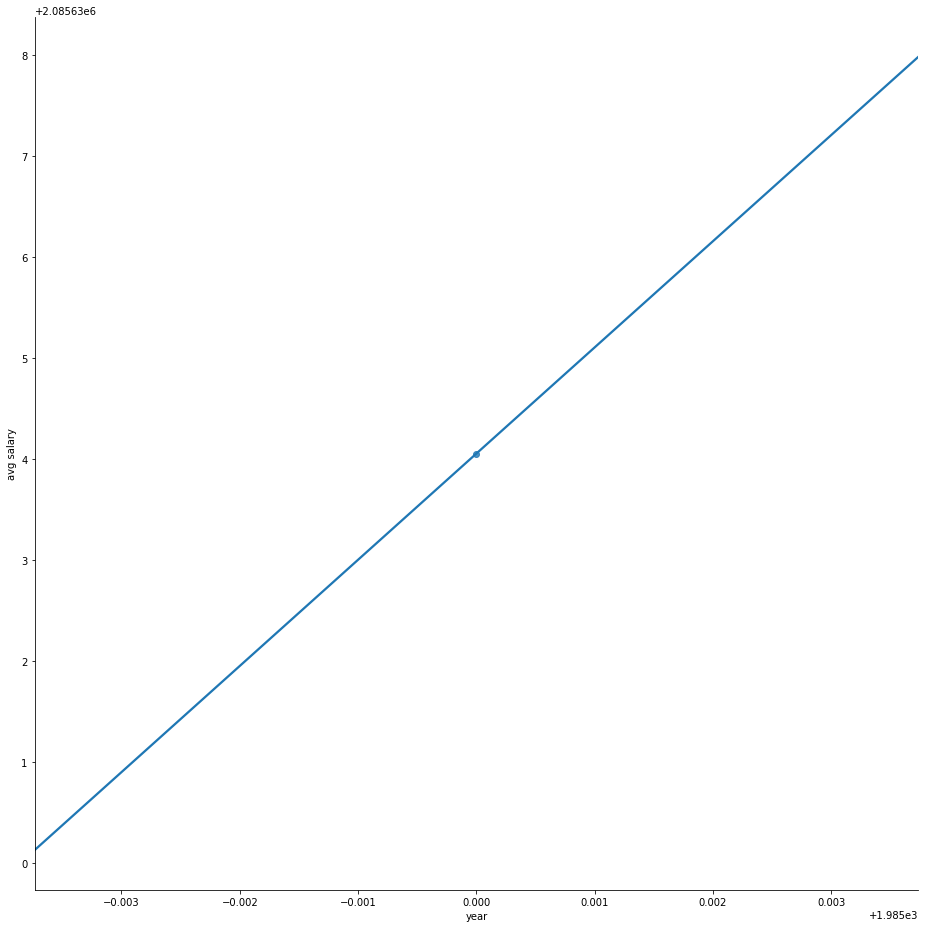

In [13]:
import matplotlib.pyplot as plt 
import seaborn as sns

def query_visualisation(connection, column_names, start_year=1985, end_year=2016):
    query="""
    SELECT      s.yearID as year, AVG(s.salary) as avg_salary
    FROM        Salaries as s
    WHERE       s.yearID >= {} AND s.yearID <= {}
    GROUP BY    s.yearID;
    """.format(start_year, end_year)

    #stap 2&3
    r = run_query(connection, query) #query uitvoeren
    frame = pd.DataFrame(r, columns=['year', 'avg_salary'], dtype="float") #query in dataframe zetten
    return frame

data1 = query_visualisation(c, column_names, start_year=1985, end_year=2016)
sns.lmplot(data=data1, x="year", y="avg_salary", fit_reg=True, size=13)

In [ ]:
def query_visualisation1(connection,column_names, start_year=1985,end_year=2016, playerID = "perryge01"):
    query="""
    SELECT      s.yearID as year, s.playerID as player, s.salary as salary
    FROM        Salaries as s, master as m
    WHERE       s.yearID >= {} AND s.yearID <= {} and s.playerID = m.playerID and s.playerID = "{}"
    GROUP BY    s.yearID, s.playerID;
    """.format(start_year, end_year, playerID)
    
    #stap 2&3
    r = run_query(connection, query)
    frame = pd.DataFrame(r, columns=['year','player', 'salary'], dtype="float") #query in dataframe zetten
    return frame

data2 = query_visualisation1(c, column_names, start_year=1985, end_year=2016)
sns.lmplot(data=data2,x='year',y='salary', hue="player", fit_reg=False, size=13)